In [4]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
apcodes = pd.read_csv(r'C:\Users\agadiraju\OneDrive - Alignment Healthcare\Desktop\CO\data\Airport_Codes.csv')
flights = pd.read_csv(r'C:\Users\agadiraju\OneDrive - Alignment Healthcare\Desktop\CO\data\flights.csv', low_memory=False)
tickets = pd.read_csv(r'C:\Users\agadiraju\OneDrive - Alignment Healthcare\Desktop\CO\data\tickets.csv')

In [6]:
flights.head()
#apcodes.head()
#tickets.head()

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.0,-6.0,0.0,143.0,1025.0,0.97
1,2019-03-02,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1.0,5.0,0.0,135.0,930.0,0.55
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0.0,4.0,0.0,132.0,930.0,0.91
3,2019-03-02,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",11.0,14.0,0.0,136.0,930.0,0.67
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",0.0,-17.0,0.0,151.0,1005.0,0.62


In [7]:
myflights=flights
mytickets=tickets
#pd.set_option('display.max_rows', 500)

In [196]:
################################## Cleaning AirPort Codes Data ##################################
#apcodes.query('TYPE=="medium_airport" or TYPE=="large_airport"')['NAME'].count() #5146
#apcodes.query('TYPE=="medium_airport" or TYPE=="large_airport"')['IATA_CODE'].nunique() #4453
myapcodes=apcodes.query('(TYPE=="medium_airport" or TYPE=="large_airport") and ISO_COUNTRY=="US"')
myapcodes=myapcodes[myapcodes['IATA_CODE'].notna()]

myapcodesNA=apcodes[(apcodes['IATA_CODE'].isna()) & (apcodes['ISO_COUNTRY']=='US') 
        & ((apcodes['TYPE']=='medium_airport') | (apcodes['TYPE']=='large_airport'))]
myapcodesNA=myapcodesNA[~myapcodesNA.duplicated()] #Making sure to remove dups


myapcodes[myapcodes.duplicated('IATA_CODE')] #dups check
myapcodes=myapcodes[~myapcodes.NAME.str.contains("Duplicate")]
myapcodes=myapcodes[~myapcodes.duplicated()] # Remove dups 

##remove dups exp: ITIN_ID 201912152497



In [207]:
################################## Cleaning Flights Data ##################################

myflights=myflights[~myflights.duplicated()] # Remove duplicates #1915886 after dedup 1911341
myflights['DISTANCE_New'] = myflights['DISTANCE'].replace(['Hundred', '****','Twenty','nan','NAN'], [100, 0,20,0,0]).astype(float)
myflights=myflights.query('DISTANCE_New >125')  # Assuming minimum distance betwn cities to operate # 1851774
myflights=myflights[myflights['CANCELLED']==0] # Filtered calcelled flights # 1802506
myflights=myflights[(myflights['ARR_DELAY'].notna()) | (myflights['AIR_TIME'].notna())] # removing missing flight data # 1798237

myflights['ISSUE_FLAG']=0 #myflights['ISSUE_FLAG'].astype(int)
myflights['TripIdentifier']=myflights['ORIGIN']+"-"+myflights['DESTINATION']
myflights['OCCUPANCY']=myflights['OCCUPANCY_RATE']*200

myflights['FL_DATE_New']= pd.to_datetime(myflights['FL_DATE'])

#flights[flights['OP_CARRIER_FL_NUM']=='ARD'] #ACA distance too long, DDD,YUD,ARD airtime too small

myflights['ISSUE_FLAG'] = np.where((myflights['OP_CARRIER_FL_NUM'] == 'ARD') 
        | (myflights['OP_CARRIER_FL_NUM'] == 'DDD') | (myflights['OP_CARRIER_FL_NUM'] == 'YUD') 
        | (myflights['OP_CARRIER_FL_NUM'] == 'ACA'),1,myflights['ISSUE_FLAG'])

myflights['AIR_TIME_New'] = myflights['AIR_TIME'].replace(['$$$','Two'], [0,2]).astype(float)
#myflights['AIR_TIME_New'] = myflights['AIR_TIME_New'].fillna(value)




######  Metrics  #######
myflights['FOMC_Cost']=myflights['DISTANCE_New']*8
myflights['DIO_Cost']=myflights['DISTANCE_New']*1.18

myflights['DELAY_COST']=np.where(myflights['DEP_DELAY']>15,(myflights['DEP_DELAY']-15)*75,0)
myflights['Baggage']=myflights['OCCUPANCY']*0.5*70 # For round trips only use caution
# Fix AIR_TIME Nans and ARR_DELAY

In [203]:
################################## Merging ##################################

myflights_airport=myflights.merge(myapcodes[['TYPE','IATA_CODE']], how='left', left_on='ORIGIN',right_on='IATA_CODE')
myflights_airport=myflights_airport.rename(columns={'TYPE': 'ORI_TYPE', 'IATA_CODE': 'ORI_CODE'})

myflights_airport=myflights_airport.merge(myapcodes[['TYPE','IATA_CODE']], how='left', left_on='DESTINATION',right_on='IATA_CODE')
myflights_airport=myflights_airport.rename(columns={'TYPE': 'DES_TYPE', 'IATA_CODE': 'DES_CODE'})


myflights_airport['ORI_CODE'].isna().sum() # 16757
myflights_airport['DES_CODE'].isna().sum() # 16752
#myflights_airport[(myflights_airport['ORI_TYPE'].isna()) | (myflights_airport['DES_TYPE'].isna())] # 32745 

#Assuming $7,500 as Ope cost for airports with missing IATA_CODE
myflights_airport['OPE_COST']=np.where(myflights_airport['ORI_TYPE']=='medium_airport',5000,
                              np.where(myflights_airport['ORI_TYPE']=='large_airport',10000, 
                               np.where(myflights_airport['ORI_TYPE'].isna(),7500,0 ))) + np.where(myflights_airport['DES_TYPE']=='medium_airport',5000,
                              np.where(myflights_airport['DES_TYPE']=='large_airport',10000, 
                               np.where(myflights_airport['DES_TYPE'].isna(),7500,0 )))



In [ ]:
################################## Cleaning Tickets Data ##################################

mytickets.count() #1167285

mytickets.isna().sum()
mytickets[mytickets['PASSENGERS'].isna()].count()/tickets['PASSENGERS'].count()*100 #0.16% pass missing data
mytickets=mytickets[mytickets['PASSENGERS'].notna()] #Removing 0.16% of data with missing pass data # 1165308

mytickets[mytickets['ITIN_FARE'].isna()].count()/tickets['PASSENGERS'].count()*100 #0.08% ITIN_FARE missing data
mytickets=mytickets[mytickets['PASSENGERS'].notna()] #Removing 0.16% of data with missing pass data # 1165308

mytickets['ITIN_FARE_New']=mytickets['ITIN_FARE'].astype(str).str.extractall('(\d+).').unstack().fillna('').sum(axis=1).astype(int)


mytickets.dtypes

In [9]:
#deepu work
flights_sort=myflights[['ORIGIN','DESTINATION']].apply(sorted,axis=1)
flights_sort.head()


0    [CLE, RSW]
1    [CMH, RSW]
2    [CMH, RSW]
3    [CMH, RSW]
4    [DAL, RSW]
dtype: object

In [205]:
myflights_airport.count()
#myflights_airport.dtypes


FL_DATE              1798237
OP_CARRIER           1798237
TAIL_NUM             1798237
OP_CARRIER_FL_NUM    1798237
ORIGIN_AIRPORT_ID    1798237
ORIGIN               1798237
ORIGIN_CITY_NAME     1798237
DEST_AIRPORT_ID      1798237
DESTINATION          1798237
DEST_CITY_NAME       1798237
DEP_DELAY            1798237
ARR_DELAY            1798237
CANCELLED            1798237
AIR_TIME             1798206
DISTANCE             1798237
OCCUPANCY_RATE       1798237
DISTANCE_New         1798237
ISSUE_FLAG           1798237
TripIdentifier       1798237
OCCUPANCY            1798237
FL_DATE_New          1798237
AIR_TIME_New         1798206
FOMC_Cost            1798237
DIO_Cost             1798237
DELAY_COST           1798237
ORI_TYPE             1782884
ORI_CODE             1782884
DES_TYPE             1782944
DES_CODE             1782944
OPE_COST             1798237
dtype: int64

In [211]:
flights['FL_DATE'].count()

1915886

In [216]:
################################## Some Stats ##################################

print('% of Flights data filtered', round((1-myflights['FL_DATE'].count()/flights['FL_DATE'].count())*100,2),'%')


print('% of itineraries with Passangers >=10 are', round( (mytickets[mytickets['PASSENGERS']>=10].count()['PASSENGERS'] 
                                                  / mytickets['PASSENGERS'].count())*100,2),'%')

% of Flights data filtered 6.14 %
% of itineraries with Passangers >=10 are 2.72 %


In [247]:
myapcodes[myapcodes.duplicated('IATA_CODE')]
#apcodes[apcodes['IATA_CODE']=='JNB']
myflights.head()
apcodes['IATA_CODE'].unique()
apcodes[apcodes['IATA_CODE']=='JNB']

array([nan, 'UTK', 'OCA', ..., 'SHE', 'YNJ', 'YKH'], dtype=object)

In [298]:
myapcodes[myapcodes['IATA_CODE']=='LAX']
myapcodes['ISO_COUNTRY'].unique()


,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES


In [240]:
myapcodes[myapcodes['ISO_COUNTRY']=='US']
myapcodes[myapcodes.duplicated('IATA_CODE')]
#myapcodes[myapcodes['IATA_CODE'].notna()]

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES


In [180]:
myapcodes.count()

TYPE            4459
NAME            4459
ELEVATION_FT    4415
CONTINENT       3073
ISO_COUNTRY     4448
MUNICIPALITY    4095
IATA_CODE       4459
COORDINATES     4459
dtype: int64

In [243]:
myflights.count() #1915886

FL_DATE              1915886
OP_CARRIER           1915886
TAIL_NUM             1903730
OP_CARRIER_FL_NUM    1915886
ORIGIN_AIRPORT_ID    1915886
ORIGIN               1915886
ORIGIN_CITY_NAME     1915886
DEST_AIRPORT_ID      1915886
DESTINATION          1915886
DEST_CITY_NAME       1915886
DEP_DELAY            1865535
ARR_DELAY            1859895
CANCELLED            1915886
AIR_TIME             1859335
DISTANCE             1915256
OCCUPANCY_RATE       1915576
ISSUE_FLAG           1915886
TripIdentifier       1915886
OCCUPANCY            1915576
FL_DATE_New          1915886
AIR_TIME_New         1859325
DISTANCE_New         1915256
FOMC_Cost            1915256
DIO_Cost             1915256
dtype: int64

In [105]:
mytickets.head()

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION,NewFare,TripIdentifier
0,201912723049,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,736.0,DAB,736.0,ABI-DAB
1,201912723085,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,570.0,COS,570.0,ABI-COS
2,201912723491,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,564.0,MCO,564.0,ABI-MCO
3,201912723428,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,345.0,LGA,345.0,ABI-LGA
4,201912723509,2019,1,ABI,US,TX,Texas,0.0,MQ,1.0,309.0,MGM,309.0,ABI-MGM


In [ ]:
mytickets.query('(ORIGIN=="ABE" & DESTINATION == "ABQ") or (ORIGIN=="ABQ" & DESTINATION == "ABE")') #.to_csv('ABQ-MSP.csv')

4453

In [206]:
#myflights[myflights['ORIGIN_CITY_NAME']=='Munda Airport']
myapcodes.count()
myapcodes[myapcodes.duplicated('IATA_CODE')]



,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
20106,large_airport,OR Tambo International Airport,5558.0,AF,ZA,Johannesburg,JNB,"28.246, -26.1392"
25112,large_airport,O R Tambo International,5558.0,AF,ZA,Johannesburg,JNB,"28.246, -26.1392"
39766,medium_airport,KÅchi RyÅma Airport,42.0,AS,JP,Nankoku,KCZ,"133.669006, 33.546101"
42574,medium_airport,Zona da Mata Regional Airport,1348.0,SA,BR,Juiz De Fora,IZA,"-43.1730575562, -21.5130558014"
55237,medium_airport,Yangzhou Taizhou Airport,7.0,AS,CN,Yangzhou and Taizhou,YTY,"119.7198, 32.5634"


In [204]:
apcodes['TYPE'].unique()


,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
30949,medium_airport,CastellÃ³n-Costa Azahar Airport,1145.0,EU,ES,CastellÃ³n de la Plana,CDT,"0.073333, 40.213889"


In [7]:
############   Validation Examples   ############
#tickets[tickets['ITIN_ID']==201915871] # multiple and repeating dest infor for same iter id
#tickets[tickets['ITIN_ID']==201912545927] #org - dest is 1300 miles and fair seems like error
#tickets[tickets['ITIN_ID']==201913235979] # dup and too expensive $377K
#tickets[tickets['ITIN_ID']==201913236036] # dup and too expensive $375K
tickets[tickets['ITIN_ID']==201913394818] # single ticket $38K

tickets[tickets['ITIN_FARE']=='820$$$'] # has string values itin id = 201913102587

mytickets[mytickets['PASSENGERS']==180]


myapcodes[myapcodes['IATA_CODE']=='JNB']  # duplicates

myapcodes[myapcodes['IATA_CODE'].notna()]['ISO_COUNTRY'].unique()

myflights[(myflights['OP_CARRIER_FL_NUM']=='3223') & (myflights['FL_DATE']=='3/2/19')] #Dups in data


#myflights[myflights['AIR_TIME'].isna()].iloc[:,-20:]
myflights[(myflights['ARR_DELAY'].isna()) | (myflights['AIR_TIME'].isna())].count()


,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
968736,201913394818,2019,1,SLC,US,UT,Utah,1.0,OO,1.0,38400.0,TWF


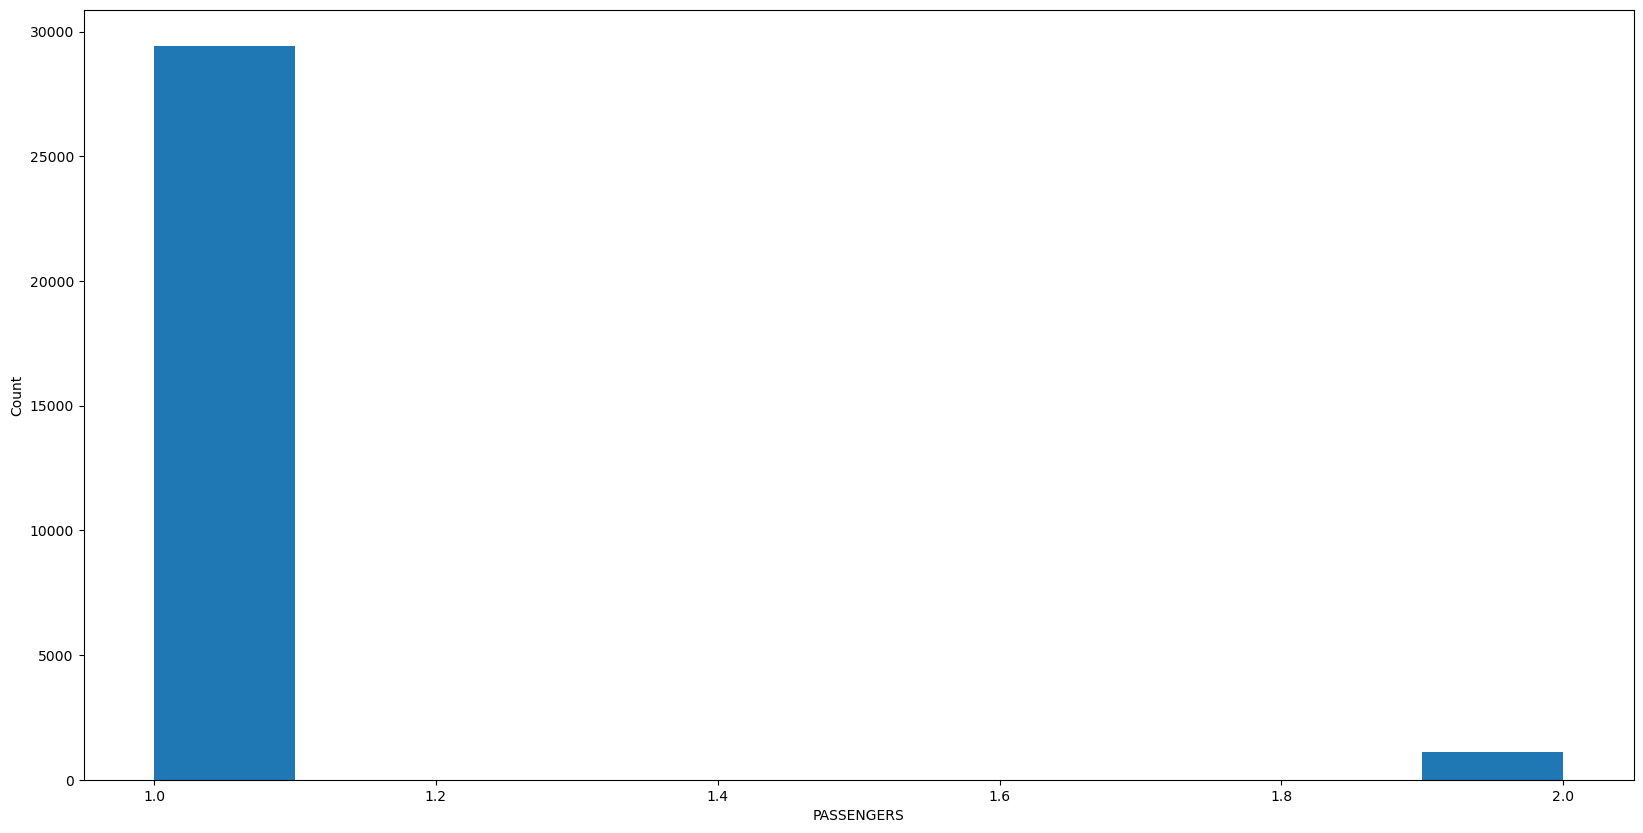

In [12]:
tickets.dtypes
tickets['PASSENGERS'].max()
## create dist graph for pass & cost
plt.figure(figsize=(20,10))

tickets[tickets['PASSENGERS']>=10.0].value_counts().plot(kind='hist', bins=10)

plt.xlabel('PASSENGERS')

plt.ylabel('Count')

plt.show()


<AxesSubplot:>

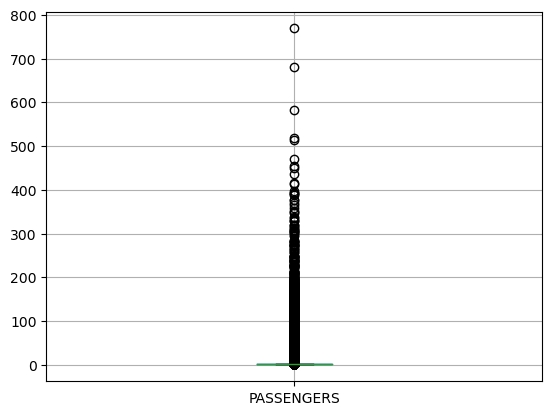

In [111]:
tickets.boxplot(column=['PASSENGERS'])

<AxesSubplot:xlabel='PASSENGERS'>

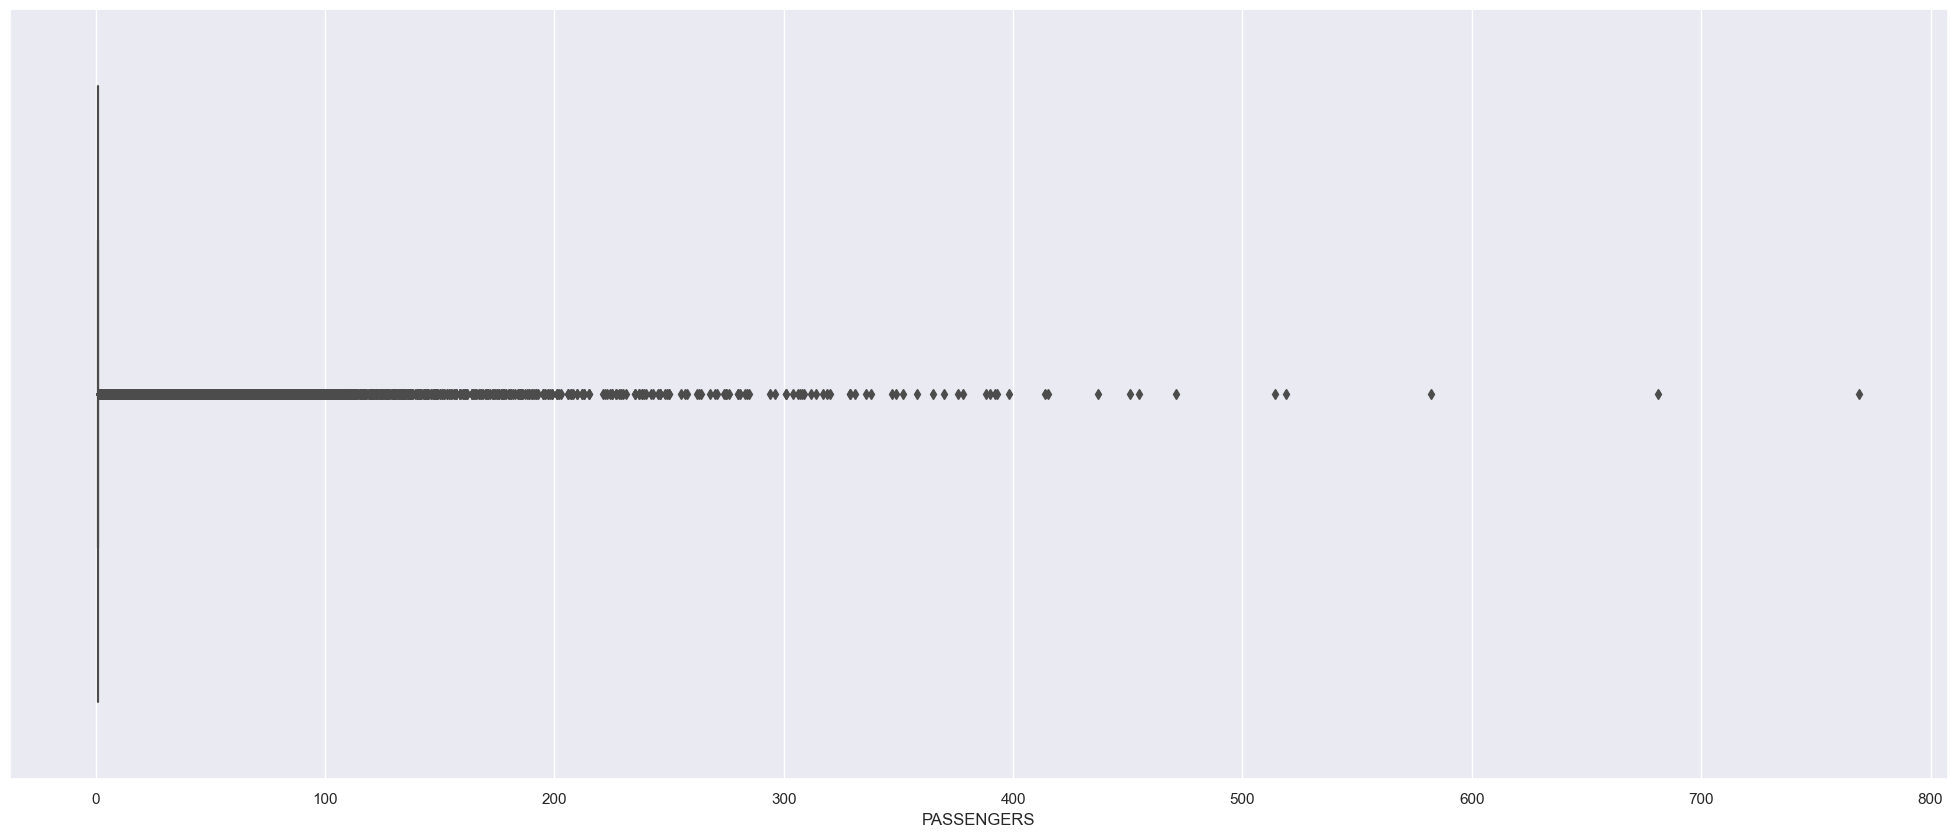

In [136]:
#sns.boxplot(column=tickets['PASSENGERS'], axis=1)
plt.figure(figsize=(25,10))
sns.boxplot(x=tickets['PASSENGERS'],)
#sns.distplot(tickets['PASSENGERS'], ax=ax_hist)

In [107]:

myflights.query('(ORIGIN=="ABQ" & DESTINATION == "MSP") or (ORIGIN=="MSP" & DESTINATION == "ABQ")')

mytickets.query('(ORIGIN=="ABE" & DESTINATION == "ABQ") or (ORIGIN=="ABQ" & DESTINATION == "ABE")') #.to_csv('ABQ-MSP.csv')
#[tickets['OP_CARRIER_FL_NUM']=='4591']
#tickets.query('ITIN_ID==201911258986')

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION,NewFare,TripIdentifier
52240,201913100519,2019,1,ABE,US,PA,Pennsylvania,1.0,OO,1.0,631.0,ABQ,631.0,ABE-ABQ
52603,201911535487,2019,1,ABE,US,PA,Pennsylvania,1.0,DL,1.0,437.0,ABQ,437.0,ABE-ABQ
52620,201912445206,2019,1,ABE,US,PA,Pennsylvania,0.0,EV,1.0,522.0,ABQ,522.0,ABE-ABQ
